# Dano's braindecode  notebook

In this notebook, I try and use the braindecode Experiment quickstart to learn some neurodoro data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

In [64]:
# Data has been collected, let's import it

data = pd.read_csv("../muse-data/josh_sep_21RawEEG2.csv", header=0, index_col=False)

In [65]:
# Remove all the early epochs before the experiment started

data = data[data.Performance != 0]

In [66]:
# State is handcoded in right now to make this a classification problem. We should work an algorithm to compute this state from performance and difficulty

data['State'] = 1
data.loc[data.Difficulty > 40, 'State'] = 2
data.iloc[52000:, data.columns.get_loc('State')] = 3

# rearrange columns, remove timestamp
data = data[['Difficulty', 'Performance', 'State', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']]

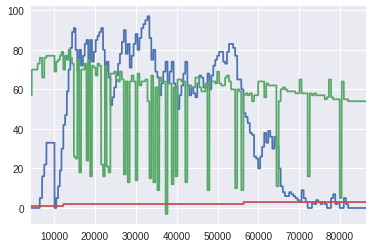

In [67]:
%matplotlib inline
data.Difficulty.plot()
data.Performance.plot()

data.State.plot()

In [68]:
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'Perf', 'State', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] * 3 + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data
data = data.T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=7, n_times=81936
    Range : 0 ... 81935 =      0.000 ...   320.059 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-69-c492566b21b4>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[3]);
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


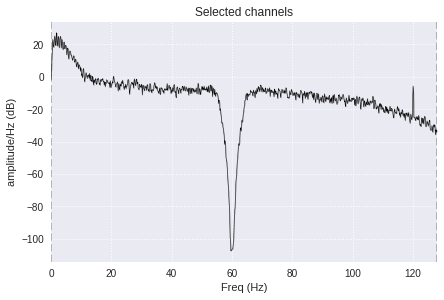

In [69]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[3]);


In [70]:
raw.filter(2, 50, method='iir',picks=([3,4,5,6]))

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 7 x 81936 (320.1 sec), ~4.4 MB, data loaded>

## Epochs

In [71]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=2, preload=True, reject={'eeg': 200})

epochs

640 matching events found
0 projection items activated
Loading data for 640 events and 513 original time points ...
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['

<Epochs  |  n_events : 612 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : (None, 0), ~16.8 MB, data loaded>

In [72]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(612, 4, 513) (612, 3)


In [73]:
# The labels matrix has three columns, Difficulty (0) and Performance (1) and State (2)

# We'll need to use our State variable for decode (it only does classification not regression rn)
y = y[:,2]

In [74]:
# Let's grab some new test data from Josh's other trial

data = pd.read_csv("../muse-data/josh_sep_21_distracted_RawEEG0.csv", header=0, index_col=False)
data = data[data.Performance != 0]
data['State'] = 1
data.loc[data.Difficulty > 40, 'State'] = 2
data.iloc[49000:, data.columns.get_loc('State')] = 3
data = data[['Difficulty', 'Performance', 'State', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']]
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'Perf', 'State', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] * 3 + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data
data = data.T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))
raw.filter(2, 50, method='iir',picks=([3,4,5,6]))
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=2, preload=True, reject={'eeg': 200})

X_test = epochs.copy().pick_types(eeg=True).get_data()

y_test = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
y_test = np.round(y_test[:,2])

Creating RawArray with float64 data, n_channels=7, n_times=80484
    Range : 0 ... 80483 =      0.000 ...   314.387 secs
Ready.
Setting up band-pass filter from 2 - 50 Hz
628 matching events found
0 projection items activated
Loading data for 628 events and 513 original time points ...
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10']
    Rejecting  epoch based on EEG : ['TP9', 'FP2', 'TP10']
    Rejecting  epoch based on EE

In [75]:
# Convert to braindecode format
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.datautil.splitters import split_into_two_sets


X = (X* 1e6).astype(np.float32)
y = y.astype(np.int)

X_test = (X* 1e6).astype(np.float32)
y_test = y.astype(np.int)

train_set = SignalAndTarget(X, y=y)
test_set = SignalAndTarget(X_test, y=y_test)
train_set, valid_set = split_into_two_sets(train_set, first_set_fraction=0.8)

In [76]:
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 450
n_classes = 4
in_chans = train_set.X.shape[1]
# final_conv_length determines the size of the receptive field of the ConvNet
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes, input_time_length=input_time_length,
                        final_conv_length=12).create_network()
to_dense_prediction_model(model)

if cuda:
    model.cuda()

In [77]:
from torch import optim

optimizer = optim.Adam(model.parameters())

In [78]:
out = model(test_input)

In [79]:
from braindecode.torch_ext.util import np_to_var
# determine output size
test_input = np_to_var(np.ones((2, in_chans, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
#out = model(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

187 predictions per input/trial


In [80]:
# need to setup python logging before to be able to see anything
import logging
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

In [81]:
from braindecode.experiments.experiment import Experiment
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.experiments.monitors import RuntimeMonitor, LossMonitor, CroppedTrialMisclassMonitor, MisclassMonitor
from braindecode.experiments.stopcriteria import MaxEpochs
import torch.nn.functional as F
from braindecode.torch_ext.modules import Expression
# Iterator is used to iterate over datasets both for training
# and evaluation
iterator = CropsFromTrialsIterator(batch_size=32,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

# Loss function takes predictions as they come out of the network and the targets
# and returns a loss
loss_function = lambda preds, targets: F.nll_loss(th.mean(preds, dim=2, keepdim=False), targets)

# Could be used to apply some constraint on the models, then should be object
# with apply method that accepts a module
model_constraint = None
# Monitors log the training progress
monitors = [LossMonitor(), MisclassMonitor(col_suffix='sample_misclass'),
            CroppedTrialMisclassMonitor(input_time_length), RuntimeMonitor(),]
# Stop criterion determines when the first stop happens
stop_criterion = MaxEpochs(20)
exp = Experiment(model, train_set, valid_set, test_set, iterator, loss_function, optimizer, model_constraint,
          monitors, stop_criterion, remember_best_column='valid_misclass',
          run_after_early_stop=True, batch_modifier=None, cuda=cuda)

In [82]:
import torch as th
exp.run()

2017-09-22 15:27:13,370 INFO : Run until first stop...
2017-09-22 15:27:18,279 INFO : Epoch 0
2017-09-22 15:27:18,281 INFO : train_loss                13.49374
2017-09-22 15:27:18,282 INFO : valid_loss                73.05371
2017-09-22 15:27:18,283 INFO : test_loss                 49.23673
2017-09-22 15:27:18,287 INFO : train_sample_misclass     0.33415
2017-09-22 15:27:18,288 INFO : valid_sample_misclass     1.00000
2017-09-22 15:27:18,290 INFO : test_sample_misclass      0.44444
2017-09-22 15:27:18,291 INFO : train_misclass            0.30408
2017-09-22 15:27:18,293 INFO : valid_misclass            1.00000
2017-09-22 15:27:18,294 INFO : test_misclass             0.44444
2017-09-22 15:27:18,296 INFO : runtime                   0.00000
2017-09-22 15:27:18,297 INFO : 
2017-09-22 15:27:18,301 INFO : New best valid_misclass: 1.000000
2017-09-22 15:27:18,302 INFO : 
2017-09-22 15:27:25,274 INFO : Time only for training updates: 6.87s
2017-09-22 15:27:29,962 INFO : Epoch 1
2017-09-22 15:27

2017-09-22 15:28:53,664 INFO : train_misclass            0.16122
2017-09-22 15:28:53,665 INFO : valid_misclass            0.18852
2017-09-22 15:28:53,666 INFO : test_misclass             0.65686
2017-09-22 15:28:53,667 INFO : runtime                   10.45144
2017-09-22 15:28:53,669 INFO : 
2017-09-22 15:28:53,671 INFO : New best valid_misclass: 0.188525
2017-09-22 15:28:53,673 INFO : 
2017-09-22 15:28:59,467 INFO : Time only for training updates: 5.71s
2017-09-22 15:29:04,030 INFO : Epoch 10
2017-09-22 15:29:04,031 INFO : train_loss                0.36305
2017-09-22 15:29:04,032 INFO : valid_loss                0.66428
2017-09-22 15:29:04,033 INFO : test_loss                 74.61018
2017-09-22 15:29:04,034 INFO : train_sample_misclass     0.12558
2017-09-22 15:29:04,034 INFO : valid_sample_misclass     0.28991
2017-09-22 15:29:04,035 INFO : test_sample_misclass      0.65686
2017-09-22 15:29:04,036 INFO : train_misclass            0.10000
2017-09-22 15:29:04,037 INFO : valid_misclass

2017-09-22 15:30:38,370 INFO : train_misclass            0.05714
2017-09-22 15:30:38,371 INFO : valid_misclass            0.13934
2017-09-22 15:30:38,372 INFO : test_misclass             0.65686
2017-09-22 15:30:38,374 INFO : runtime                   10.41712
2017-09-22 15:30:38,375 INFO : 
2017-09-22 15:30:38,378 INFO : New best valid_misclass: 0.139344
2017-09-22 15:30:38,379 INFO : 
2017-09-22 15:30:44,156 INFO : Time only for training updates: 5.69s
2017-09-22 15:30:48,700 INFO : Epoch 20
2017-09-22 15:30:48,701 INFO : train_loss                0.29003
2017-09-22 15:30:48,702 INFO : valid_loss                0.90228
2017-09-22 15:30:48,703 INFO : test_loss                 153.03478
2017-09-22 15:30:48,704 INFO : train_sample_misclass     0.11303
2017-09-22 15:30:48,705 INFO : valid_sample_misclass     0.34034
2017-09-22 15:30:48,706 INFO : test_sample_misclass      0.65686
2017-09-22 15:30:48,707 INFO : train_misclass            0.10204
2017-09-22 15:30:48,708 INFO : valid_misclas

Best Epoch:
```
2017-09-22 11:15:15,655 INFO : Epoch 6
2017-09-22 11:15:15,656 INFO : train_loss                0.55220
2017-09-22 11:15:15,661 INFO : valid_loss                0.17202
2017-09-22 11:15:15,664 INFO : test_loss                 0.55220
2017-09-22 11:15:15,665 INFO : train_sample_misclass     0.19732
2017-09-22 11:15:15,675 INFO : valid_sample_misclass     0.05496
2017-09-22 11:15:15,683 INFO : test_sample_misclass      0.19732
2017-09-22 11:15:15,686 INFO : train_misclass            0.13667
2017-09-22 11:15:15,692 INFO : valid_misclass            0.00833
2017-09-22 11:15:15,695 INFO : test_misclass             0.13667
2017-09-22 11:15:15,698 INFO : runtime                   11.22553

```